In [2]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (12,10) # setting default figure size
pylab.style.use('ggplot') # setting style

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.offsets import *
from datetime import datetime as dt
from datetime import timedelta

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from sklearn.linear_model import LinearRegression
from sklearn.covariance import graphical_lasso
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from numba import jit

import wrds
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

lmts = importr('LongMemoryTS')
utils = importr('utils')

# db = wrds.Connection(wrds_username='fannywu')
# import Portfolio.PortHelper as ph
# import pdblp
# con = pdblp.BCon(debug=False, port=8194, timeout=50000)
# con.start()

S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
name_query = """
              select a.permno,  a.namedt, a.ticker, a.comnam
              from crsp.dsenames as a
              where a.exchcd between 1 and 3
              """

name_df = db.raw_sql(name_query)
name_df['permno'] = name_df['permno'].astype(int)
name_df['namedt'] = pd.to_datetime(name_df['namedt'])
name_df.drop_duplicates(['permno','ticker'],inplace=True)

permno_list = pd.read_csv('permno_list.csv',index_col=0)['ticker_list'].to_list()
N = len(permno_list)
ret_dict = {}
for n, permno in enumerate(permno_list):
    
    stock_query = """
                  select a.permno, a.permco, a.date, b.shrcd, b.exchcd, a.ret
                  from crsp.dsf as a
                  left join crsp.dsenames as b
                  on a.permno=b.permno
                  and b.namedt<=a.date
                  and a.date<=b.nameendt
                  where a.date between '01/01/1920' and '12/31/2020'
                  and b.exchcd between 1 and 3
                  and a.permno = {} 
                  """.format(permno)
    stock_df = db.raw_sql(stock_query)
    
    stock_df.index = pd.to_datetime(stock_df['date'])
    stock_df.drop(columns='date', inplace=True)
    ret_dict[permno] = stock_df['ret'].copy()
    
    if n % 500 is 0:
        print('{:.2f}% of permnos completed...'.format(n*100/N))
        
with open('ret_dict.pkl', 'wb') as handle:
    pickle.dump(ret_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
ret_dict = pd.read_pickle('ret_dict.pkl')
for permno in ret_dict.keys():
    ret_dict[permno] = ret_dict[permno].to_frame('ret')
    ret_dict[permno]['permno'] = int(permno)

ret_df = pd.concat(ret_dict, axis=0).droplevel(axis=0, level=0).reset_index()
del ret_dict

spx_const = db.get_table('crsp','dsp500list')
spx_const['start'] = pd.to_datetime(spx_const['start'])
spx_const['ending'] = pd.to_datetime(spx_const['ending'])
spx_const['permno'] = spx_const['permno'].astype(int)

ret_df = ret_df.merge(spx_const,how='left', on='permno')
ret_df.dropna(axis=0, subset=['start','ending'], inplace=True)
spx_days_ix = (ret_df['date'] >= ret_df['start']) & \
                        (ret_df['date'] <= ret_df['ending'])
ret_df = ret_df[spx_days_ix].copy()
ret_df.reset_index(drop=True, inplace=True)
ret_df.to_pickle('ret_df.pkl')

In [5]:
ret_df = pd.read_pickle('ret_df.pkl')
ret_df.drop(columns=['start', 'ending'], inplace=True)
ret_df = ret_df.pivot_table(values='ret',index='date', columns='permno')

Text(0.5, 1.0, 'Number of Firms')

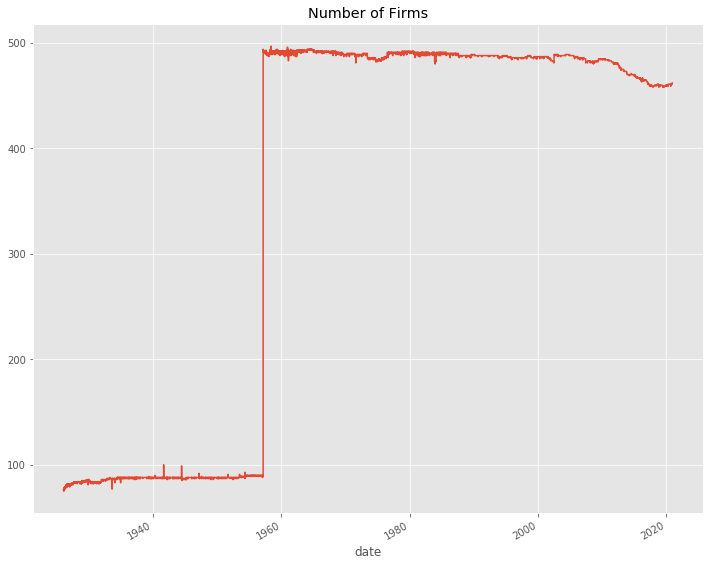

In [4]:
ret_df.groupby(ret_df.index.get_level_values(0)).count().sum(axis=1).plot()
plt.title('Number of Firms')

In [7]:
start_date = '1960/01'
corr_lkbk = int(252*5)
min_periods = int(252*3)
test_l = int(252/2)
t_0 = 10000


ret_df = ret_df[start_date:].copy()
df = ret_df.iloc[t_0:(t_0 + corr_lkbk + test_l)].dropna(axis=1, how='all')
test_full_ids = df.iloc[corr_lkbk:].dropna(axis=1,how='any').columns
min_miss_train_ids = df.iloc[:corr_lkbk][::-1].iloc[:min_periods].isnull().sum()
train_full_ids = min_miss_train_ids.index[min_miss_train_ids == 0]
asset_ids = train_full_ids.intersection(test_full_ids)

In [7]:
df = df[asset_ids]
cov_mat = df[:corr_lkbk].cov(min_periods=min_periods)

In [7]:
df = df[asset_ids]
covmat = df[:corr_lkbk].cov(min_periods=min_periods)


corr = cov_to_corr(cov.values)
corr_den = get_denoised_corr(corr, corr_lkbk)
cov_den = corr_to_cov(corr_den, diag_vols(cov))

# n_pc = 15
# syst_cov, idio_cov = factor_cov(cov_den, n_pc)
# idio_corr = pd.DataFrame(cov_to_corr(idio_cov),
#                          columns=cov.columns,
#                          index=cov.columns)
# idio_corr

NameError: name 'cov_to_corr' is not defined

In [254]:
def inertia(labels, data):
    W = [
        np.mean(pairwise_distances(data[labels == label]))
        for label in np.unique(labels)
    ]
    return np.mean(W)

def gap_statistic(model, data, k_max=10, n_randoms=10):
    e_w_k_rand = []
    sd_k = []
    w_k = []
    gap = []
    for k in range(1, k_max + 1):
        w_k_rand = []
        model.n_clusters = k
        for _ in range(n_randoms):
            rand_data = np.random.rand(data.shape[0],
                                       data.shape[1])
            np.fill_diagonal(rand_data, 0)
            labels = model.fit_predict(rand_data)
            w_k_rand.append(np.log(inertia(labels, rand_data)))
        e_w_k_rand.append(np.mean(w_k_rand))
        sd_k.append(np.std(w_k_rand) * np.sqrt(1+ 1/n_randoms))
        data_labels = model.fit_predict(data)
        w_k.append(inertia(data_labels, data))
        gap.append(e_w_k_rand[k-1] - w_k[k-1])

    clust_measure = (np.array(gap)[:-1] - (np.array(gap)[1:] - np.array(sd_k)[1:]))
    clust_range = np.arange(1, k_max)
    opt_k = clust_range[clust_measure > 0][0]
    
    return gap, clust_measure, opt_k
    
model = AgglomerativeClustering()
dist = ((1 - corr_den) / 2)**(0.5)
k_max = 15
n_randoms = 30
_,_,k = gap_statistic(model, dist, k_max=k_max, n_randoms=n_randoms)
hi_clust = AgglomerativeClustering(n_clusters=k).fit(dist)

In [283]:
from sklearn.covariance import GraphicalLassoCV
cluster = 0
const = df.columns[hi_clust.labels_ == cluster]

#N = cov_den.shape[0]
X = df.iloc[:corr_lkbk][const].dropna().values
model = GraphicalLassoCV(n_jobs=10)
model.fit(X)
inv_cov = model.precision_
diag_inv = np.sqrt(np.diag(inv_cov).reshape(-1,1))**(-1)
a = diag_inv @ diag_inv.T
pcorr_mat = -(a*inv_cov)
np.fill_diagonal(pcorr_mat, 1)

In [ ]:
def get_glasso_pcorr(X):
    model = GraphicalLassoCV(n_jobs=10)
    model.fit(X)
    inv_cov = model.precision_
    pcorr_mat = get_inv_pcorr(inv_cov)
    return model, pcorr_mat

def get_inv_pcorr(inv_cov):
    diag_inv = np.sqrt(np.diag(inv_cov).\
                       reshape(-1, 1))**(-1)
    a = diag_inv @ diag_inv.T
    pcorr_mat = -(a * inv_cov)
    np.fill_diagonal(pcorr_mat, 1)
    return pcorr_mat

In [284]:
pcorr_df = pd.DataFrame(pcorr_mat, index=const, columns=const)
pair_df = get_sorted_paircorr(pcorr_df)

{10890: [14593],
 14593: [43916, 27051],
 14883: [25160],
 18921: [24643],
 27115: [56266, 48071],
 27596: [49905],
 27828: [61241],
 41718: [47079],
 43916: [61241],
 47079: [48071],
 48071: [48354],
 49905: [75030]}

In [297]:
x =	10604
y = 14891
X = df[[x,y]].apply(lambda x: 1+x).dropna().fillna(method='ffill').cumprod()
test_coint_pairs(X[x], X[[y]], alpha=0.05)

S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,s1,t1,p1,t2,p2,k_ar_diff,trace0,trace1,trace_sig,eg_sig
s2,,,,,,,,,,
14891,10604,-2.620794,0.229348,-2.748231,0.182713,4,10.834318,0.399339,0,0


In [350]:
x =	10604
y = 14891
X = df[[x,y]].apply(lambda x: 1+x).dropna().fillna(method='ffill').cumprod()

In [298]:
frac_coint_test(X.values, m_peri=25, alpha=0.05)

{'T_n': 2.005647590137036, 'crit.value': 1.3859038243496775, 'reject': 1}

In [300]:
beta = X.corr().loc[x,y] * (X.std()[x]/X.std()[y])
calc_hurst_exponent((X[x]- beta*X[y]).values)

(0.5008914763647602,
 0.0012366126331777583,
 array([0.44956631, 0.60498975, 0.76503651, 0.89721317, 0.99123821,
        1.09880553, 1.21740077, 1.35552329, 1.47770743, 1.5777091 ]),
 array([1.        , 1.23044892, 1.49136169, 1.74818803, 2.        ,
        2.24797327, 2.49968708, 2.74973632, 3.        , 3.14176323]))

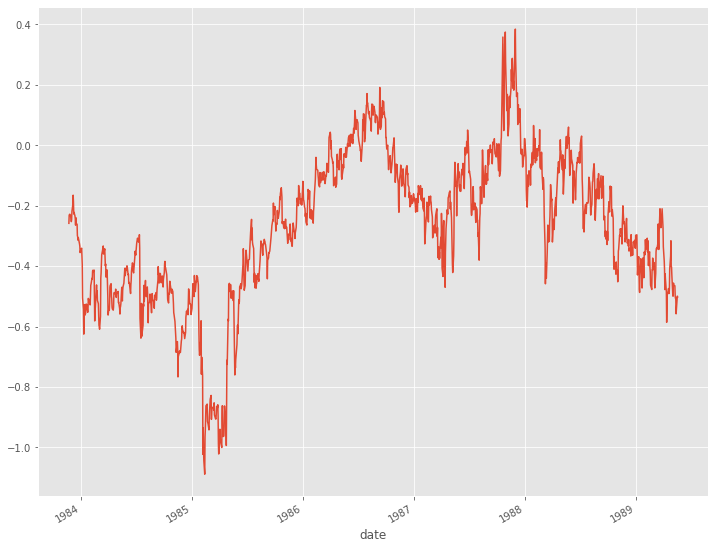

In [301]:
(X[x]-beta*X[y]).plot()

(-1.1110257805529284,
 1.1110257861127815,
 -1.1132309392150064,
 1.1132309420070134)

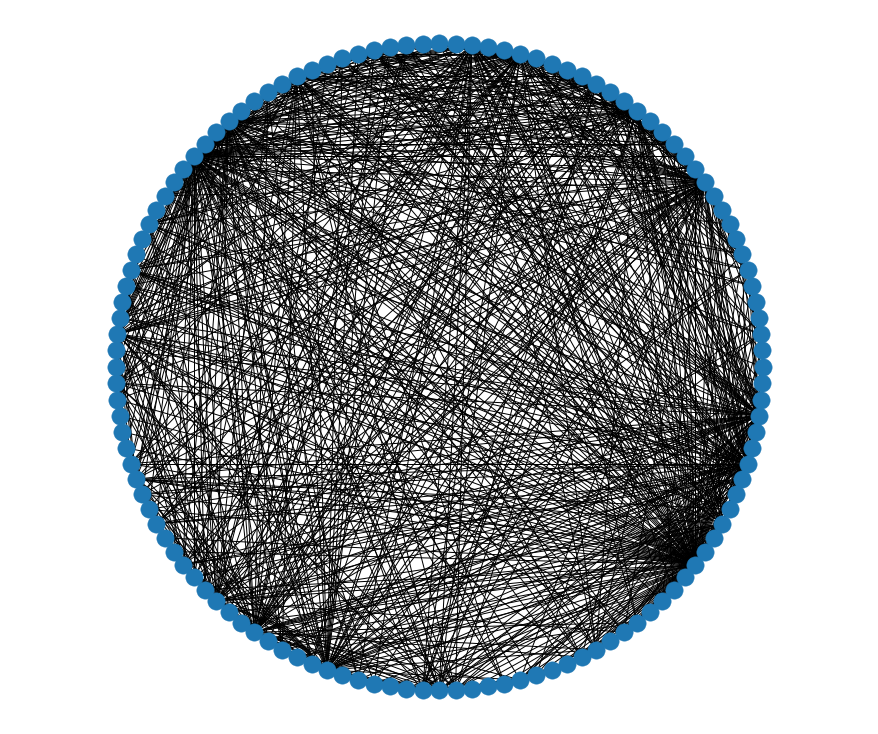

In [299]:
from scipy.sparse import csr_matrix
import networkx as nx
rho_sparse = nx.from_scipy_sparse_matrix(csr_matrix(pcorr_df.values))
nx.draw_circular(rho_sparse)
plt.axis('equal')


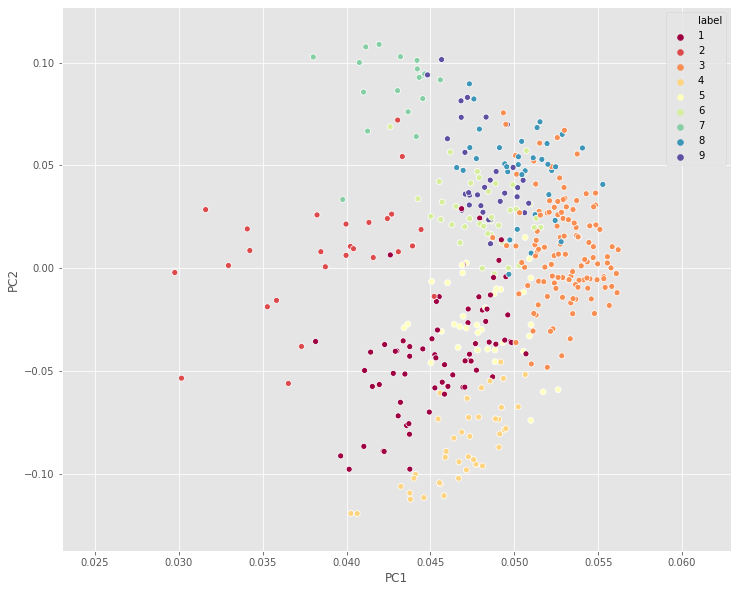

In [233]:
e, v = get_pca(corr_den)
pc = pd.DataFrame(v[:,:2], index = df.columns, columns=['PC1','PC2'])
pc['label'] = hi_clust.labels_+1
pc['label'] = pc['label'].astype(int)
sns.scatterplot('PC1','PC2', 'label', data=pc, palette='Spectral', legend='full')

In [30]:
def cov_to_corr(cov):
    vols = np.sqrt(np.diag(cov)).reshape(-1,1)
    corr = ((1/vols) @ (1/vols).T) * cov
    return corr

def corr_to_cov(corr, vols):
    vols = vols.reshape(-1,1)
    return ((vols) @ (vols).T) * corr

def diag_vols(cov):
    return np.sqrt(np.diag(cov))

def factor_cov_decomp(cov, n_pc):
    e, v = np.linalg.eigh(cov)
    idx = e.argsort()[::-1]
    e = e[idx]
    v = v[:,idx]
    L = v[:,:n_pc] @ np.diag(np.sqrt(e[:n_pc]))
    syst_cov = L @ L.T
    idio_cov = cov - syst_cov
    return syst_cov, idio_cov

def get_sorted_paircorr(corr):

    triu_ix=np.triu_indices_from(corr,1)
    pair_df = pd.DataFrame(index=range(len(triu_ix[0])))
    pair_df['A1'] = list(corr.columns[triu_ix[0]])
    pair_df['A2'] = list(corr.columns[triu_ix[1]])
    pair_df['corr'] = corr.values[triu_ix]
#     pair_df['corr'] = ((1 - pair_df['corr']) / 2)**(0.5)
    pair_df.sort_values('corr',ascending=False, inplace=True)
    return pair_df

In [130]:
dev = 2
stop_short = 0.75
stop_long = 0.50
h = 8.3

test_df = pd.read_csv('pairs_data_test.csv', index_col=0).dropna()
test_df['spread'] = test_df['NIFTY'].apply(np.log).div(test_df['MSCI'].apply(
    np.log))
test_df['spread_ma'] = test_df['spread'].rolling(10).mean()
test_df['spread_sd'] = test_df['spread'].rolling(10).std()
test_df['z_spread'] = (test_df['spread'] - test_df['spread_ma'].shift(1))/test_df['spread_sd'].shift(1)

test_df['signal'] = 0
test_df['signal'] = np.where(test_df['z_spread'] < -dev, 1, test_df['signal'])
test_df['signal'] = np.where(test_df['z_spread'] > dev, -1, test_df['signal'])
test_df['stop_signal'] = 0
test_df['status'] = 0
stop_idx = (test_df['z_spread'] > -stop_long) & (test_df['z_spread'] < stop_short)
test_df['stop_signal'] = np.where(stop_idx, 1, test_df['stop_signal'])

signal = test_df['signal'].values
stop_signal = test_df['stop_signal'].values
test_df['status'] = get_trade_status(signal, stop_signal)
test_df[['r_msci','r_nifty']] = test_df[['MSCI','NIFTY']].pct_change()
test_df['spread_return'] = test_df['r_nifty'] - h*test_df['r_msci']
test_df['strat_returns'] = test_df['spread_return']*test_df['status'].shift(1)

@jit(nopython=True)
def get_trade_status(signal, stop_signal):
    status = [0]
    for ix in range(1, len(signal)):
        if (status[ix - 1] == 0) | \
        ((status[ix - 1] == 0) & (stop_signal[ix - 1] == 1)):
            status.append(signal[ix])
        elif (status[ix - 1] != 0) & (stop_signal[ix] == 1):
            status.append(0)
        elif (status[ix - 1] != 0) & (signal[ix] != 0):
            status.append(signal[ix])
        else:
            status.append(status[ix - 1])
            
    return status

In [3]:
# fut_df = con.bdh(['GX1 A:03_0_R Index', 'SP1 A:03_0_R Index'],
#                  'PX_LAST', 
#                  '19900101', '20201231').droplevel(axis=1, level=1).dropna()
# rv_df = fut_df.apply(np.log).ewm(halflife=21).std().dropna()

price_df = pd.read_csv('spx_holdings_and_spx_closeprice_m2-ex4.csv', index_col=0).drop(columns='SPX')
rets_df = price_df.pct_change(1).dropna()

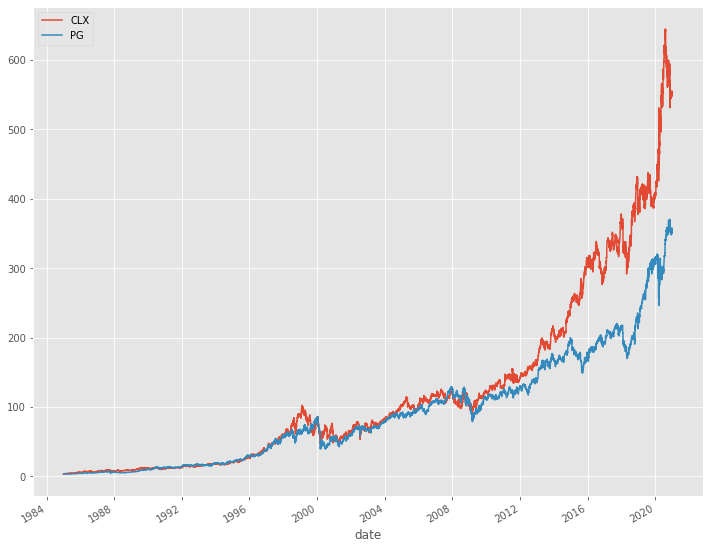

In [10]:
tickers = ['CLX US Equity', 'PG US Equity']
ids = ['CLX', 'PG']
price_df = con.bdh(tickers, 'TOT_RETURN_INDEX_GROSS_DVDS', 
             '19850101', '20201231').droplevel(axis=1, level=1)
price_df.columns = ids
# price_df = pd.read_pickle('price.pkl')
price_df.plot()

In [128]:
def fit_ols(X, y, add_constant=True):
    if add_constant:
        X = sm.add_constant(X)
    return sm.OLS(y, X, missing='drop').fit()


class SpreadOLS:
    def __init__(self, train, test, tickers):
        self.train = train
        self.test = test
        self.y = tickers[0]
        self.x = tickers[1]
        self.model = fit_ols(self.train[self.x], self.train[self.y])

    def get_pairs_params(self):
        self.beta = self.model.params[1]
        self.mu_eps = self.model.params[0]
        self.vol_eps = self.get_spreads(self.train).std()
        return self.beta, self.mu_eps, self.vol_eps

    def get_spreads(self, X):
        return X[self.y].sub(X[self.x] * self.beta)

    def get_z_spreads(self, test=True, get_params=False):
        if get_params:
            self.get_pairs_params()
        if test:
            return (self.get_spreads(self.test) - self.mu_eps) / self.vol_eps
        else:
            return (self.get_spreads(self.train) - self.mu_eps) / self.vol_eps


def get_ewm_zscore(spreads, hl):
    return spreads.subtract(spreads.ewm(halflife=hl).mean()).divide(
        spreads.ewm(halflife=hl).std())


def get_threshold_rule(score, long_point=1, short_point=1):
    if score <= -long_point:
        return 1
    elif score >= short_point:
        return -1
    elif (score > -long_point) & (score < short_point):
        return 0


def calc_ls_rets(log_prices, h, position, tickers, dollar_neutral=True):

    if dollar_neutral:
        if h > 1.0:
            return position.multiply(((1 / h) * log_prices[tickers[0]] -
                                      log_prices[tickers[1]]).diff(),
                                     axis=0)
        elif h < 1.0:
            return position.multiply(
                (log_prices[tickers[0]] - h * log_prices[tickers[1]]).diff(),
                axis=0)
    else:
        return position.multiply(
            (log_prices[tickers[0]] - h * log_prices[tickers[1]]).diff(),
            axis=0)


def get_johansen_stat(df, k_ar_diff):

    n, k = df.shape
    j_test = coint_johansen(df, 0, k_ar_diff)
    tr_stat = j_test.lr1
    tr_signf = j_test.cvt
    for i in range(k):
        if tr_stat[i] > tr_signf[i, 1]:
            r = i + 1
    j_test.r = r
    j_test.evecr = j_test.evec[:, :r]

    return j_test


def calc_coint_stats(security, candidate, results=True):
    df = pd.DataFrame({'s1': security, 's2': candidate})
    var = VAR(df)
    lags = var.select_order()
    k_ar_diff = lags.selected_orders['aic']

    cj0 = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)

    t1, p1 = coint(security, candidate, trend='c')[:2]
    t2, p2 = coint(candidate, security, trend='c')[:2]
    if results:
        return [security.name, candidate.name, t1, p1, t2, p2, k_ar_diff, *cj0.lr1]
    else:
        return results, cj0 


def test_coint_pairs(security, candidates, alpha=0.05):

    security = security.div(security.iloc[0])
    candidates = candidates.div(candidates.iloc[0])

    critical_values = {
        0: {
            .90: 13.4294,
            .95: 15.4943,
            .99: 19.9349
        },
        1: {
            .90: 2.7055,
            .95: 3.8415,
            .99: 6.6349
        }
    }
    trace0_cv = critical_values[0][
        1 - alpha]  # critical value for 0 cointegration relationships
    trace1_cv = critical_values[1][
        1 - alpha]  # critical value for 1 cointegration relationship

    tests = []
    for idx, prices in candidates.items():
        # sprinkling a bit of noise to make them reduce collinearity
        eps = 1e-5 * np.random.rand(security.shape[0], 2)
        security = (security.pct_change(1) +
                    eps[:, 0]).apply(lambda x: 1 + x).fillna(1).cumprod()
        prices = (prices.pct_change(1) +
                  eps[:, 1]).apply(lambda x: 1 + x).fillna(1).cumprod()
        tests.append(calc_coint_stats(security, prices))

    columns = [
        's1', 's2', 't1', 'p1', 't2', 'p2', 'k_ar_diff', 'trace0', 'trace1'
    ]
    tests = pd.DataFrame(tests, columns=columns).set_index('s2')
    tests['trace_sig'] = ((tests.trace0 > trace0_cv) &
                          (tests.trace1 > trace1_cv)).astype(int)
    tests['eg_sig'] = tests.apply(lambda x: int(
        (x['p1'] < alpha) & (x['p2'] < alpha)),
                                  axis=1)
    return tests


def frac_coint_test(X, m_peri=25, alpha=0.05):
    """
    Semiparametric residual-based test for fractional
    cointegration by Chen, Hurvich (2003). Returns test 
    statistic, critical value and testing decision. 
    Null hypothesis: no fractional cointegration
    
    
    """
    
    numpy2ri.activate()
    n, k = X.shape
    X_r = robjects.r.matrix(X, nrow=n, ncol=k)

    coint_test = lmts.FCI_CH06(X_r,
                               m_peri=robjects.Vector(m_peri), 
                               alpha=alpha,
                               m=robjects.Vector(np.floor(len(X_r)**0.65)))
    CH_dict = {}
    for name, val in coint_test.items():
        CH_dict[name] = np.array(val)[0]
    numpy2ri.deactivate()
    return CH_dict


def get_r_s(x):

    r_t = x[1:] - x[:-1]
    mu = np.sum(r_t) / (len(r_t) - 1)
    r_t_dm = r_t - mu
    y_t = r_t_dm.cumsum()
    R_n = np.max(y_t) - np.min(y_t)
    s_n = np.std(r_t, ddof=1)
    if (R_n != 0.0) & (s_n != 0.0):
        R_s = R_n / s_n
        return R_s
    else:
        return 0.0


def calc_hurst_exponent(x):

    if len(x) < 100:
        raise ValueError(
            "log price series length must be greater than or equal to 100")
    min_size = 10
    max_size = len(x) + 1
    window_sizes = list(
        map(lambda x: int(10**x),
            np.arange(np.log10(min_size), np.log10(max_size), 0.25)))
    window_sizes.append(len(x))
    R_s = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(x), w):
            if (start + w) > len(x):
                break
            r_s = get_r_s(x[start:(start + w)])
            if r_s != 0:
                rs.append(r_s)
        R_s.append(np.mean(rs))
    H = np.polyfit(np.log10(window_sizes), np.log10(R_s), 1)[0]
    C = 2**(2 * H - 1) - 1
    return H, C, np.log10(R_s), np.log10(window_sizes)


def calc_half_life(x):
    
    y_t = np.subtract(x[1:], x[:-1])
    X_t = np.vstack([np.ones(len(x[:-1])), x[:-1]]).T

    coefs = np.linalg.inv(X_t.T @ X_t) @ X_t.T @ y_t
    return -np.log(2) / coefs[1]

In [42]:
frac_coint_test(rv_df.loc['2000/01':'2020/01',:].values)

{'T_n': 1.935876233336312, 'crit.value': 1.3859038243496775, 'reject': 1}

In [37]:
# FI.sim(T=T, q=2, rho=0.4, d=c(0.4,0.4))
# x = lmts.FI_sim(robjects.Vector(2000), robjects.Vector(2), B=robjects.r.matrix(np.array([[1,-1],[0,1]]), nrow=2, ncol=2),
#                 rho=robjects.Vector(0.4), d=robjects.Vector(np.array([0.10,1.0])))

# coint_test = lmts.FCI_CH06(x,
#                            m_peri=robjects.Vector(25), 
#                            alpha=0.05,
#                            m=robjects.Vector(np.floor(2000**0.65)))
# coint_test

In [ ]:
# fcvar = importr('FCVAR')
# numpy2ri.activate()
# X = robjects.r.matrix(rv_df.values, nrow=rv_df.shape[0], ncol=rv_df.shape[1])

# opt = fcvar.FCVARoptions()
# opt.slots['gridSearch'] = robjects.Vector(0)
# opt.slots['dbMin'] = robjects.Vector(np.array([0.01,0.01]))
# opt.slots['dbMax'] = robjects.Vector(np.array([2.0,2.0]))
# opt.slots['constrained'] = robjects.Vector(0)
# opt.slots['plotLike'] = robjects.Vector(0)
# opt.slots['plotRoots'] = robjects.Vector(0)
# opt.slots['gridSearch'] = robjects.Vector(0)
# opt.slots['print2screen'] = robjects.Vector(0)
# opt.slots['printRoots'] = robjects.Vector(0)

# k = 4
# r = 1
# model = fcvar.FCVARestn(X, k, r, opt)

# out = {}
# for name, vals in model.items():
#     out[name] = vals
    
# numpy2ri.deactivate()

In [28]:
df = price_df.div(price_df.iloc[0]).apply(np.log).fillna(method='ffill').copy()
# test = df.iloc[(ix+in_sample-1):oos_frame,:].copy()
# train = df.iloc[ix:(ix+in_sample),:].copy()
tickers = ['CLX', 'PG']
in_sample = 252
oo_sample = 120
strat_df = pd.DataFrame()
burn_in = 5
for ix in range(0, len(df) - oo_sample, oo_sample):

    train = df.iloc[ix:(ix + in_sample), :].copy()
    hl = int(calc_half_life((train[tickers[0]] - train[tickers[1]]).values))
    h_exp = calc_hurst_exponent((train[tickers[0]] - train[tickers[1]]).values)[0]
    if ix >= int(in_sample*10):
        coint_test = frac_coint_test(df[(ix-int(9*in_sample)):(ix + in_sample)].values, alpha=0.05)['reject']
    else:
        coint_test = frac_coint_test(df[:(ix + in_sample)].values, alpha=0.05)['reject']
    print(coint_test)
    if coint_test:
        if (h_exp >= 0.50) & ((hl > oo_sample) | (hl < 0)):
            continue
    else:
        continue
#     if not coint_test:
#         continue

    test_frame = np.amin([(ix + in_sample + oo_sample), df.shape[0]])
    test = df.iloc[(ix + in_sample):test_frame, :].copy()

    spread_model = SpreadOLS(train.copy(), test.copy(), tickers)
    h, _, _ = spread_model.get_pairs_params()
    test_spreads = spread_model.get_z_spreads().to_frame('spreads')
#     spreads = pd.concat(
#         [spread_model.get_spreads(train)[-burn_in:],
#          spread_model.get_spreads(test)]).drop_duplicates().to_frame('spreads')
#     test_spreads = get_ewm_zscore(spreads, hl).iloc[burn_in+1:]

    test_signal = test_spreads['spreads'].apply(
        lambda x: get_threshold_rule(x,long_point=1,short_point=1)).shift(1).fillna(method='ffill')
    strat_df = pd.concat(
        [strat_df,
         calc_ls_rets(test, h, test_signal, tickers, dollar_neutral=True)],
        axis=0)

    if (df.shape[0] - (ix + oo_sample + in_sample)) < in_sample: break

0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Text(0.5, 1.0, 'Basic Mean Reversion Strat - Clorox & PG')

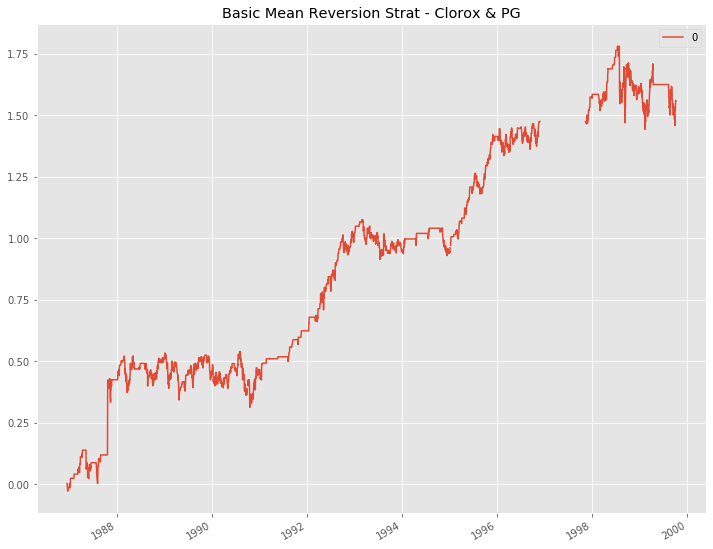

In [29]:
strat_df.cumsum().plot()
plt.title('Basic Mean Reversion Strat - Clorox & PG')

In [233]:
my_algo_strat = strat_df.copy()

In [30]:
strat_df.apply(lambda x: np.exp(x)-1).mean()*16/strat_df.apply(lambda x: np.exp(x)-1).std()

0    0.74158
dtype: float64

In [26]:
strat_df.apply(lambda x: np.exp(x)-1).mean()*16/strat_df.apply(lambda x: np.exp(x)-1).std()

0    0.839495
dtype: float64

In [129]:
price_df.to_pickle('price.pkl')

In [130]:
df

,CLX,PG
date,,
1985-01-02,1.279266,1.257210
1985-01-03,1.252763,1.250532
1985-01-04,1.266102,1.252763
1985-01-07,1.287854,1.266074
1985-01-08,1.287854,1.270463
...,...,...
2020-12-24,6.319784,5.868246
2020-12-28,6.312149,5.875193
2020-12-29,6.309724,5.873316


In [61]:
x = np.random.rand(5000,2)
numpy2ri.activate()
y = robjects.r.matrix(x, nrow=x.shape[0], ncol=x.shape[1])


In [63]:
train

,CLX,PG
date,,
2018-10-17,5.954811,5.287044
2018-10-18,5.951931,5.275954
2018-10-19,5.975607,5.360282
2018-10-22,5.964271,5.352232
2018-10-23,5.959486,5.358677
...,...,...
2019-10-11,5.985507,5.708810
2019-10-14,5.975272,5.700184
2019-10-15,5.971836,5.676158


In [77]:
from rpy2.robjects import numpy2ri
import rpy2.robjects as ro
numpy2ri.activate()
n, k = df.values.shape
X = robjects.r.matrix(df.values, nrow=n, ncol=k)

T_n
0.125319
crit.value
1.385904
reject
0


In [99]:
CH_dict

{'T_n': 0.8095856599352231, 'crit.value': 1.3859038243496775, 'reject': 0}

In [103]:
frac_coint_test(X)['reject']

0

In [2]:

import rpy2.robjects as ro

n, k = df.values.shape
Br = robjects.r.matrix(df.values, nrow=n, ncol=k)
ro.r.assign("B", Br)

NameError: name 'df' is not defined

In [4]:
ro.utils.install_packages(StrVector('glasso'))

AttributeError: module 'rpy2.robjects' has no attribute 'utils'

In [6]:
import rpy2.robjects as ro
package_name = "LongMemoryTS"

try:
    pkg = importr(package_name)
except:
    ro.r(f'install.packages("{package_name}")')
    pkg = importr(package_name)

In [13]:
packnames = ('LongMemoryTS')
utils.install_packages(StrVector(packnames))

rpy2.rinterface.NULL

In [3]:
import rpy2

import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# utils = rpackages.importr('utils')
# utils.chooseCRANmirror(ind=1)

# Install packages
# packnames = ('remotes')
# utils.install_packages(StrVector(packnames))

# Load packages
# hunspell = importr('remotes')
# hunspell.install_github("FunWithR/LongMemoryTS")
# fcvar = importr('FCVAR')

In [8]:
# R package names
packnames = ('remotes')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

In [368]:
strat_df

,0
1985-12-30,NaN
1985-12-31,NaN
1986-01-02,NaN
1986-01-03,NaN
1986-01-06,NaN
...,...
2020-04-03,0.012557
2020-04-06,0.000000
2020-04-07,-0.004084
2020-04-08,0.004140
